## Coefficient of Variation (CV) figures

Display CV across features by dose (and all)

CV measures the spread of features relative to their mean.

CV = σ / μ

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
output_figure_base <- file.path("figures", "supplementary", "cv-supfig")
extensions <- c(".png", ".pdf")

In [3]:
dose_rename <- c(dose_rename, "all" = "All")
dose_order <- c(dose_order, "All")

In [4]:
# Load CV results
cv_cutoff <- 0.3

results_dir <- file.path("..", "1.Data-exploration", "results")

input_file <- file.path(results_dir, "coefficient_of_variation.tsv.gz")

cv_cols <- readr::cols(
  feature = readr::col_character(),
  cv = readr::col_double(),
  mean = readr::col_double(),
  stddev = readr::col_double(),
  dataset = readr::col_character(),
  Metadata_dose_recode = readr::col_character()
)

cv_df <- readr::read_tsv(input_file, col_types = cv_cols) %>%
    dplyr::filter(Metadata_dose_recode != 7) %>%
    dplyr::arrange(cv) %>%
    dplyr::mutate(cv_cutoff = cv) %>%
    dplyr::mutate(dose = Metadata_dose_recode)

cv_df[((cv_df$mean > -cv_cutoff) & (cv_df$mean < cv_cutoff)), "cv_cutoff"] <- NA

cv_df$dose <- dplyr::recode_factor(cv_df$Metadata_dose_recode, !!!dose_rename)
cv_df$dose <- factor(cv_df$dose, levels = dose_order)

print(dim(cv_df))
head(cv_df, 2)

[1] 12453     8


feature,cv,mean,stddev,dataset,Metadata_dose_recode,cv_cutoff,dose
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<fct>
220127_s_at,-202158.49,-6.067057e-06,1.226670,L1000,4,NA,1.11 uM
Cells_Texture_DifferenceEntropy_AGP_5_0,-46931.76,-4.046318e-05,1.899164,Cell Painting,1,NA,0.04 uM


In [5]:
color_limits <- c(min(cv_df$cv_cutoff, na.rm = TRUE), max(cv_df$cv_cutoff, na.rm = TRUE))
color_limits

[1] -25.01949  44.51204

In [6]:
panel_a_gg = (
    ggplot(
        cv_df %>% dplyr::filter(dataset == "Cell Painting")
    )
    # + geom_vline(xintercept=cv_cutoff, linetype = "dashed", color = "grey")
    # + geom_vline(xintercept=-cv_cutoff, linetype = "dashed", color = "grey")
    + geom_point(aes(x = mean, y = stddev, fill = cv_cutoff), shape = 21, size = 0.8)
    + figure_theme
    + facet_grid("dataset~dose", scales = "free")
    + xlab("Mean")
    + ylab("Standard Deviation")
    + colorspace::scale_fill_continuous_diverging(
        name="Coefficient\nof Variation", limits = color_limits, l1 = 20, l2 = 100, p1 = 0.3, p2 = 0.9
    )
)

In [7]:
panel_b_gg = (
    ggplot(
        cv_df %>% dplyr::filter(dataset == "L1000")
    )
    # + geom_vline(xintercept=cv_cutoff, linetype = "dashed", color = "grey")
    # + geom_vline(xintercept=-cv_cutoff, linetype = "dashed", color = "grey")
    + geom_point(aes(x = mean, y = stddev, fill = cv_cutoff), shape = 21, size = 0.8)
    + figure_theme
    + facet_grid("dataset~dose", scales = "free")
    + xlab("Mean")
    + ylab("Standard Deviation")
    + colorspace::scale_fill_continuous_diverging(
        name="Coefficient\nof Variation", limits = color_limits, l1 = 20, l2 = 100, p1 = 0.3, p2 = 0.9
    )
)

In [8]:
panel_c_gg <- (
    ggplot(cv_df, aes(x = cv_cutoff))
    + geom_density(aes(fill = dataset), alpha = 0.5)
    + figure_theme
    + facet_grid("~dose")
    + xlab("Coefficient of Variation")
    + scale_fill_manual("Assay", values = assay_colors)
)

In [9]:
legend <- cowplot::get_legend(panel_a_gg)

panel_a_gg <- panel_a_gg + theme(legend.position = "none") + labs(tag = "a")
panel_b_gg <- panel_b_gg + theme(legend.position = "none") + labs(tag = "b")
panel_c_gg <- panel_c_gg + labs(tag = "c")

## Compile supplementary figure

Warning message:
“Removed 8518 rows containing non-finite values (stat_density).”


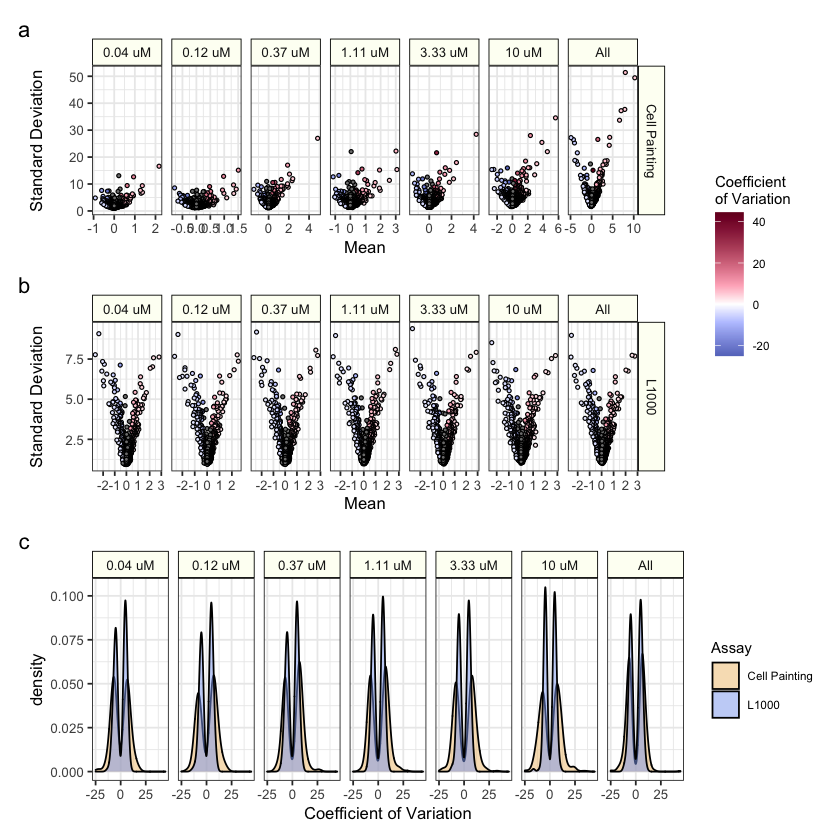

In [10]:
cv_supfig_gg <- (
    (
        (
            (
                panel_a_gg /
                panel_b_gg
            ) | (
                legend
            )
        ) + plot_layout(widths = c(1, 0.001))
    )
    / (
        panel_c_gg
    )
) + plot_layout(heights = c(1, 0.5))

cv_supfig_gg

In [11]:
for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    ggplot2::ggsave(output_file, cv_supfig_gg, height = 8, width = 8, dpi = 500)
}

Warning message:
“Removed 8518 rows containing non-finite values (stat_density).”
Warning message:
“Removed 8518 rows containing non-finite values (stat_density).”
